In [52]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# For projections (wrapped for Proj)
import pyproj

# Plotting maps using GMT
import pygmt

# The Fatiando stack
import pooch
import verde as vd
import boule as bl
import harmonica as hm

figheight=180 # in mm
# ris_xl= -400_000
# ris_yl= -500_000 #N extent
# ris_xh= -150_000
# ris_yh= -400_000 #S extent
ris_xl= -760_000
ris_yl= -1600_000 #N extent
ris_xh= 600_000
ris_yh= -350_000 #S extent
figwidth=figheight*(ris_xh-ris_xl)/(ris_yh-ris_yl)
risratio = (ris_yh - ris_yl) / (figheight/1000)
risreg = str(ris_xl) + '/' + str(ris_xh) + '/' + str(ris_yl) + '/' + str(ris_yh) #W/E/S/N
risproj = "x1:" + str(risratio)
antreg = "-3330000/1900000/-3330000/1850000"
risproj_ll = "s0/-90/-71/1:" + str(risratio)

In [60]:
ris_300km_buffer=(-900_000+300000,800_000-300000,-1800_000+300000, -100_000-300000)
grav_elev = 4000
grav_spacing = 20_000
surface = xr.load_dataarray("../inversion_layers/bedmap2_surface_WGS_84_RIS_5k_filled.nc") #"../inversion_layers/layers/bedmap2_surface_WGS_84_RIS_5k_filled.nc")
icebase = xr.load_dataarray("../inversion_layers/bedmap2_icebase_WGS_84_RIS_5k_filled.nc")#bedmap2_icebase_WGS_84_RIS_5k_filled.nc")
bed = xr.load_dataarray("../inversion_layers/bedmap2_bed_WGS_84_RIS_5k.nc")
basement = xr.load_dataarray("../inversion_layers/layers/ROSETTA_basement_bedmap2_bed.nc", drop_variables='polar_stereographic')

## Ice Layer

In [61]:
ice_density=surface.copy()
ice_density.values[:] = 900 #890 to 917 from Muto et al. 2013

In [62]:
ice_prisms=hm.prism_layer(
    coordinates=(list(surface.x), list(surface.y)),   
    surface=surface, 
    reference=icebase,
    properties={'density':ice_density},
)

In [63]:
coordinates=vd.grid_coordinates(region=ris_300km_buffer,
        spacing=grav_spacing, extra_coords=grav_elev)
ice_gravity=ice_prisms.prism_layer.gravity(
     coordinates=coordinates,
     field = 'g_z',)

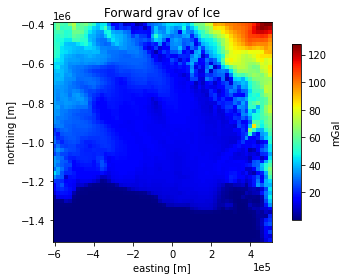

In [64]:
plt.pcolormesh(*coordinates[:2], ice_gravity, cmap='jet')
plt.colorbar(label="mGal", shrink=0.8)
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("Forward grav of Ice")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()

## Water Layer

In [65]:
water_density=surface.copy()
water_density.values[:] = 1030 #from Muto et al. 2013 

In [66]:
water_prisms=hm.prism_layer(
    coordinates=(list(surface.x), list(surface.y)),   
    surface=icebase, 
    reference=bed,
    properties={'density':water_density},
)

In [67]:
coordinates=vd.grid_coordinates(region=ris_300km_buffer,
        spacing=grav_spacing, extra_coords=grav_elev)
water_gravity=water_prisms.prism_layer.gravity(
     coordinates=coordinates,
     field = 'g_z',)

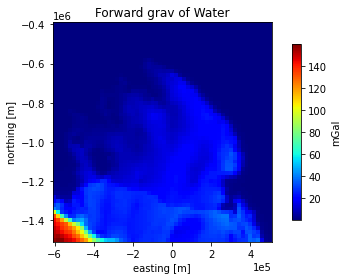

In [68]:
plt.pcolormesh(*coordinates[:2], water_gravity, cmap='jet')
plt.colorbar(label="mGal", shrink=0.8)
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("Forward grav of Water")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()

## Sediment Layer

In [69]:
sediment_density=bed.copy()
sediment_density.values[:] = 2178 #from Muto et al. 2013

In [70]:
sediment_prisms=hm.prism_layer(
    coordinates=(list(bed.x), list(bed.y)),   
    surface=bed, 
    reference=basement,
    properties={'density':sediment_density},
)

In [71]:
coordinates=vd.grid_coordinates(region=ris_300km_buffer,
        spacing=grav_spacing, extra_coords=grav_elev)
sediment_gravity=sediment_prisms.prism_layer.gravity(
     coordinates=coordinates,
     field = 'g_z',)

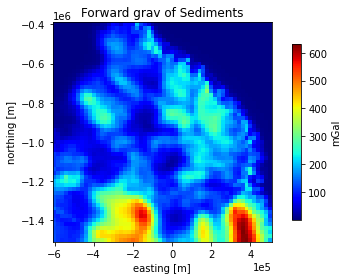

In [72]:
plt.pcolormesh(*coordinates[:2], sediment_gravity, cmap='jet')
plt.colorbar(label="mGal", shrink=0.8)
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("Forward grav of Sediments")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()

## Crust Layer

In [73]:
crust_density=basement.copy()
crust_density.values[:] = 2670 #from Muto et al. 2013

In [74]:
crust_prisms=hm.prism_layer(
    coordinates=(list(basement.x), list(basement.y)),   
    surface=basement, 
    reference=-50000,
    properties={'density':crust_density},
)

In [75]:
coordinates=vd.grid_coordinates(region=ris_300km_buffer,
        spacing=grav_spacing, extra_coords=grav_elev)
crust_gravity=crust_prisms.prism_layer.gravity(
     coordinates=coordinates,
     field = 'g_z',)

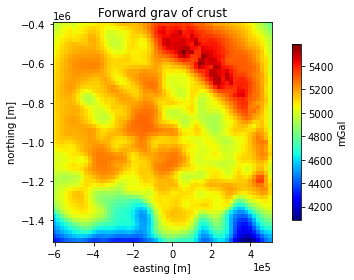

In [76]:
plt.pcolormesh(*coordinates[:2], crust_gravity, cmap='jet')
plt.colorbar(label="mGal", shrink=0.8)
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("Forward grav of crust")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()

## Add Gravity Grids Together

In [77]:
total_gravity=ice_gravity+water_gravity+sediment_gravity+crust_gravity

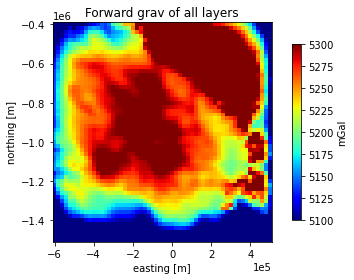

In [78]:
plt.pcolormesh(*coordinates[:2], total_gravity, cmap='jet', vmin=5100, vmax=5300)
plt.colorbar(label="mGal", shrink=0.8)
# plt.plot()
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("Forward grav of all layers")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()

### ROSETTA Gravity

In [150]:
risreg

'-760000/600000/-1600000/-350000'

In [151]:
aerograv_data = "D:/ROSETTA_Data/from_LDEO_2021/rs_2019_grav.csv"
gravity = pd.read_csv(aerograv_data)
gravity = pygmt.blockmedian(table=gravity[["x", "y", "FAG_levelled"]], 
                                         spacing="5000+e", 
                                         region=risreg)
pygmt.surface(x=gravity.x, y=gravity.y, z=gravity.FAG_levelled,
              spacing='5000+e',
              outfile="ROSETTA_gravity.nc",
              region=risreg,) 
!gmt grdmask ..\shapefiles\RIS_outline.shp -GRIS_mask.nc -I5000+e -R-760000/600000/-1600000/-350000 -NNaN/1/1
!gmt grdmath -Df ROSETTA_gravity.nc RIS_mask.nc MUL = ROSETTA_gravity.nc
!gmt grdsample ROSETTA_gravity.nc -GROSETTA_gravity.nc -T

In [165]:
gravity = xr.load_dataarray("../inversion_layers/RIS_Grav_5k.nc", drop_variables='polar_stereographic')
# gravity = xr.load_dataarray("ROSETTA_gravity.nc")
gravity

<xarray.DataArray 'Band1' (y: 183, x: 191)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float64 -5.75e+05 -5.7e+05 -5.65e+05 ... 3.7e+05 3.75e+05
  * y        (y) float64 -1.37e+06 -1.365e+06 -1.36e+06 ... -4.65e+05 -4.6e+05
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  polar_stereographic

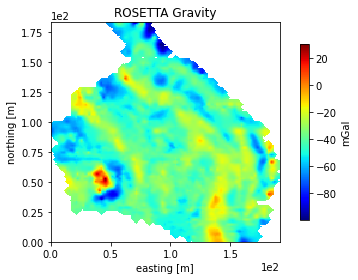

In [166]:
plt.pcolormesh(gravity, cmap='jet')
plt.colorbar(label="mGal", shrink=0.8)
plt.plot()
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("ROSETTA Gravity")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()